# Business Understanding

## Background

text

### Features

- **Net Downward Shortwave Radiation Flux [W/m^2]:** 
- **Wind Gust Surface [m/s]:** 
- **Planetary Boundary Layer Height [m]:** 
- **Mean Sea Level Pressure [pa]:** 
- **Potential Temperature Difference between 80m and 0m [K]:**
- **Specific Humidity in 2m height [1]:** 
- **Specific Humidity Mean over first 30 hPa (~250m) [1]:** 
- **Relative Humidity in 925 hPa pressure level [%]:** 
- **Relative Humidity in 950 hPa pressure level [%]:**
- **Net Sensible Heat Flux (conductive heat flux of the Earth surface to the atmosphere) [W/m^2]:**
- **Temperature in 100m height [K]:** 
- **Temperature in 2m height [K]:** 
- **Temperature Mean over first 30 hPa (~250m) [K]:** 
- **Total Cloud Cover, low level clouds (0km - 2km height) [%]:** 
- **Total Cloud Cover, mid level clouds (2km - 7km height) [%]:** 
- **Wind Direction in 100 m height [°]:** 
- **Wind Direction in 10 m height [°]:** 
- **Wind Direction Mean over first 30 hPa (~250m) [°]:** 
- **Wind Direction in 925 hPa pressure level [°]:** 
- **Wind Speed in 100 m height [m/s]:** 
- **Wind Speed in 10 m height [m/s]:** 
- **Wind Speed Mean over first 30 hPa (~250m) [°]:** 
- **Wind Speed in 925 hPa pressure level [°]:** 
- **Date and 24 Hours divided in quarters [?]:** 
- **Azimuth angle of the sun [°]:** 
- **Elevation angle of the sun [°]:** 

# Envoirment Set- Up

## Load relevant Python Packages

In [45]:
reset -fs

In [46]:
# Importing the most important modules and setting the style for following plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle


# For Data Mining
import os, glob

# For Data Cleaning
from datetime import datetime
import missingno as msno

from pandas import read_csv
from pandas import datetime

from matplotlib import pyplot
import matplotlib.dates as mdates

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

## Global Variables and Settings

In [47]:
# Setting the random seed for reproducability
%matplotlib inline
plt.style.use('seaborn')
sns.set(rc={'figure.figsize':(14,8)})
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
RSEED = 42

# Loading Datasets & First Cleaning

## GFS Data

In [48]:
# reading in the feature dataframe
with open('./data/griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_features = u.load()

In [49]:
print('First and last observations:')
pd.concat([df_features.head(2), df_features.tail(2)])

First and last observations:


,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_%,r_pl950_%,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_%,tccmedium_sfc_%,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
index,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 06:00:00+00:00,0.0,16.777032,1349.927656,99212.06250,0.559356,0.005105,0.004852,89.975,83.075,-58.444885,280.079346,280.496348,279.811816,99.375,49.50,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 07:00:00+00:00,0.0,16.606744,1352.623506,99259.81250,0.528755,0.005005,0.004739,89.250,82.250,-59.127808,279.950000,280.339922,279.664160,99.250,79.25,62.428351,59.839207,62.809819,66.607932,16.795002,9.966123,16.832585,21.917341,2018-01-01 00:00:00+00:00,122.901711,-3.799353
2019-08-26 17:00:00+00:00,217.0,6.996934,294.434175,101819.59375,0.721496,0.013280,0.011999,66.625,64.775,-17.322095,297.000000,297.050024,297.000000,0.000,0.00,253.352783,249.491241,254.108723,307.177015,6.489624,3.745793,6.426924,5.507465,2019-08-23 18:00:00+00:00,272.617737,12.060012
2019-08-26 18:00:00+00:00,79.5,8.050885,215.534009,101816.78750,1.798953,0.012720,0.011877,66.800,64.175,-38.183350,296.250000,294.969312,296.000000,0.000,0.00,250.512384,244.554716,251.835064,308.818931,7.496367,3.839874,7.413974,5.639764,2019-08-23 18:00:00+00:00,284.064789,2.764322


In [50]:
# rename columns which contains symbols
df_features = df_features.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})

## Quadra Data

In [51]:
# reading in the target dataframe
with open('./data/obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_target = u.load()

In [52]:
print('First and last observations:')
pd.concat([df_target.head(2), df_target.tail(2)])

First and last observations:


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm
2018-01-01 00:00:00+01:00,0.330269,0.450934,0.120665
2018-01-01 00:10:00+01:00,0.339204,0.457539,0.118335
2019-06-25 01:40:00+02:00,0.308457,0.338645,0.030189
2019-06-25 01:50:00+02:00,0.309148,0.339853,0.030705


## Initial Observations

**Observations:**
- **Timezones:** The timezones in the datasets are inconsistent
- **Frequency**
    - **feature data:** hourly frequency
    - **target data:** 10minute frequency
- **DataFrames**: target and feature data are in two seperate DataFrames
- **Timeframe**
    - **feature data:** 1st Jan 2018 06:00 to 26th Aug 2019 18:00
    - **target data:** 1st Jan 2018 00:00  to 25th Jun 2019 01:50



**Resulting Steps**: 
- timezones: creating consistency of timezones
- frequency: resample feature data to have 10 minute frequency
- DataFrames: Merging Data into one DataFrame
- timeframes:reducing timeframes to have overlapping timeframes


# Data Cleaning

## Timezone

In [53]:
# converting to same timezone
df_features.index = df_features.index.tz_localize(None).to_series(keep_tz=True)

In [54]:
# converting to target data to the same timezone as the feature dataframe
df_target.index = df_target.index.tz_localize(None).to_series(keep_tz=True)

## Frequency

In [55]:
# resampling to a time range of 10 minutes and interpolate between the hourly values
df_features = df_features.resample('10min', axis='index').interpolate()

## Combining DataFrames

In [56]:
# combining both dataframes to have one to work in
df = pd.concat([df_target,df_features], axis=1)

In [57]:
df.iloc[34:38,:]

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
2018-01-01 05:40:00,0.361927,0.880949,0.519021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 05:50:00,0.364547,0.891657,0.527110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,2018-01-01 00:00:00+00:00,111.880959,-12.132894
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,NaN,113.717751,-10.743970


## Continuity Check

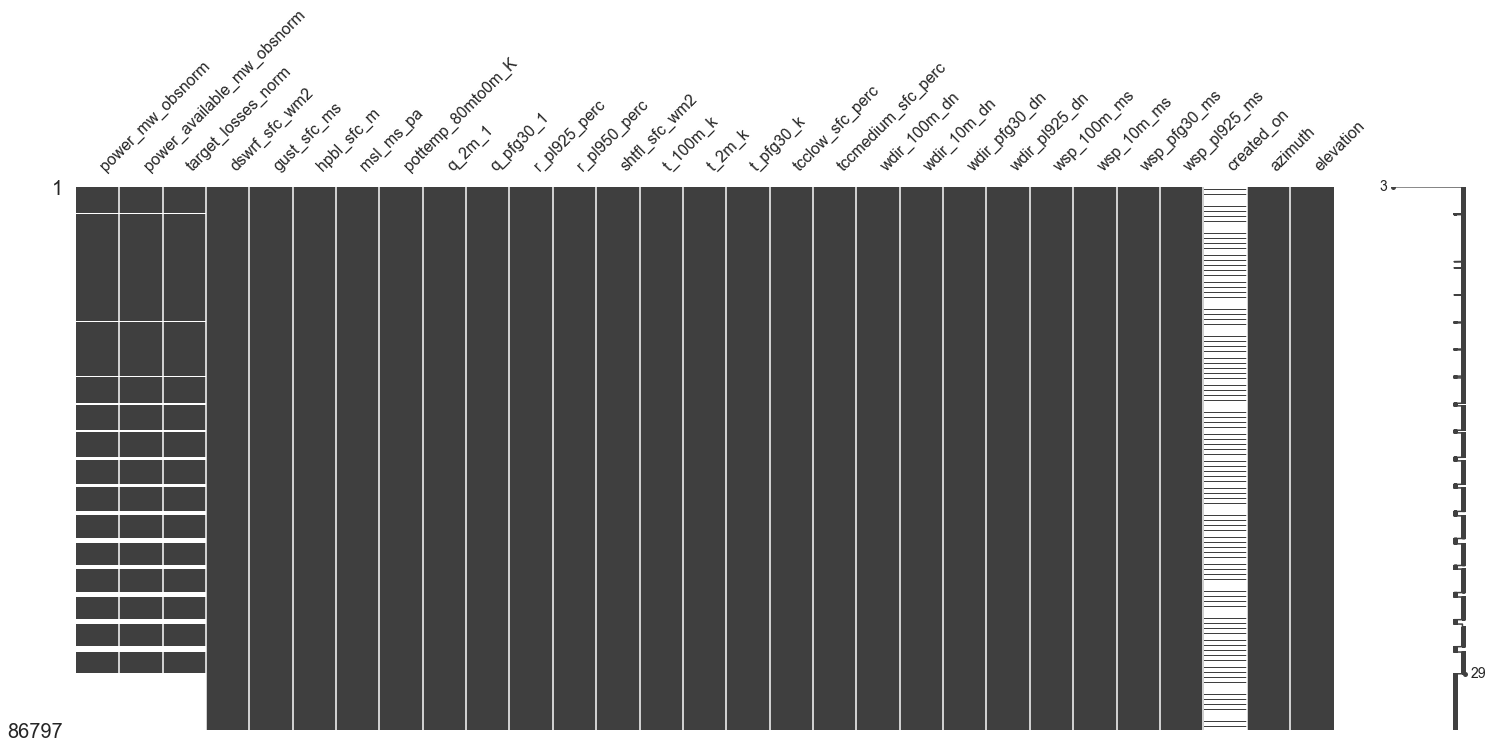

In [58]:
msno.matrix(df);

**Observations:**
- `created_on`: frequency interpolation did not work for TimeStamp data, columns will be dropped anyway. 
- target dataframe (first three coloumns): harmonisation of overall timeframe needed
- target data is uncontentious

In [59]:
# Percentage and Number of NaN-Values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
print()
print('MISSING VALUES (absolut and in percent)')
missing[missing.Number!=0].T


MISSING VALUES (absolut and in percent)


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,created_on,azimuth,elevation
Number,16087.0,16087.0,16087.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,72419.0,36.0,36.0
Percentage,18.5,18.5,18.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,83.4,0.0,0.0


## Dropping Column "created_on"

In [60]:
df.drop(columns = ["created_on"], inplace = True)

## Timeframe harmonisation

In [61]:
end_index_str = "2019-06-25 01:50:00"
end_index = pd.to_datetime(end_index_str)

start_index_str = "2018-01-01 06:00:00"
start_index = pd.to_datetime(start_index_str)

print('Start Index of united DataFrame: ', start_index)
print('End Index of united DataFrame: ', end_index)

Start Index of united DataFrame:  2018-01-01 06:00:00
End Index of united DataFrame:  2019-06-25 01:50:00


In [62]:
df = df[(df.index <= end_index) & (df.index >= start_index)]
print('First and last observations:')
pd.concat([df.head(2), df.tail(2)])

First and last observations:


,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.075000,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.937500,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970
2019-06-25 01:40:00,0.308457,0.338645,0.030189,0.0,9.875370,224.096558,102141.404167,2.363946,0.009756,0.009464,49.275000,46.033333,-50.096021,291.646208,289.825765,291.759709,0.000000,0.000000,306.634403,295.683603,309.412828,343.164726,8.642075,4.004936,8.761264,9.492873,31.591799,-9.437372
2019-06-25 01:50:00,0.309148,0.339853,0.030705,0.0,9.713995,217.509660,102131.514583,2.370229,0.009704,0.009422,48.712500,45.616667,-49.312354,291.570260,289.732206,291.704854,0.000000,0.000000,306.528820,295.343899,309.409961,343.030446,8.607915,3.982537,8.720545,9.338253,33.775887,-8.668407


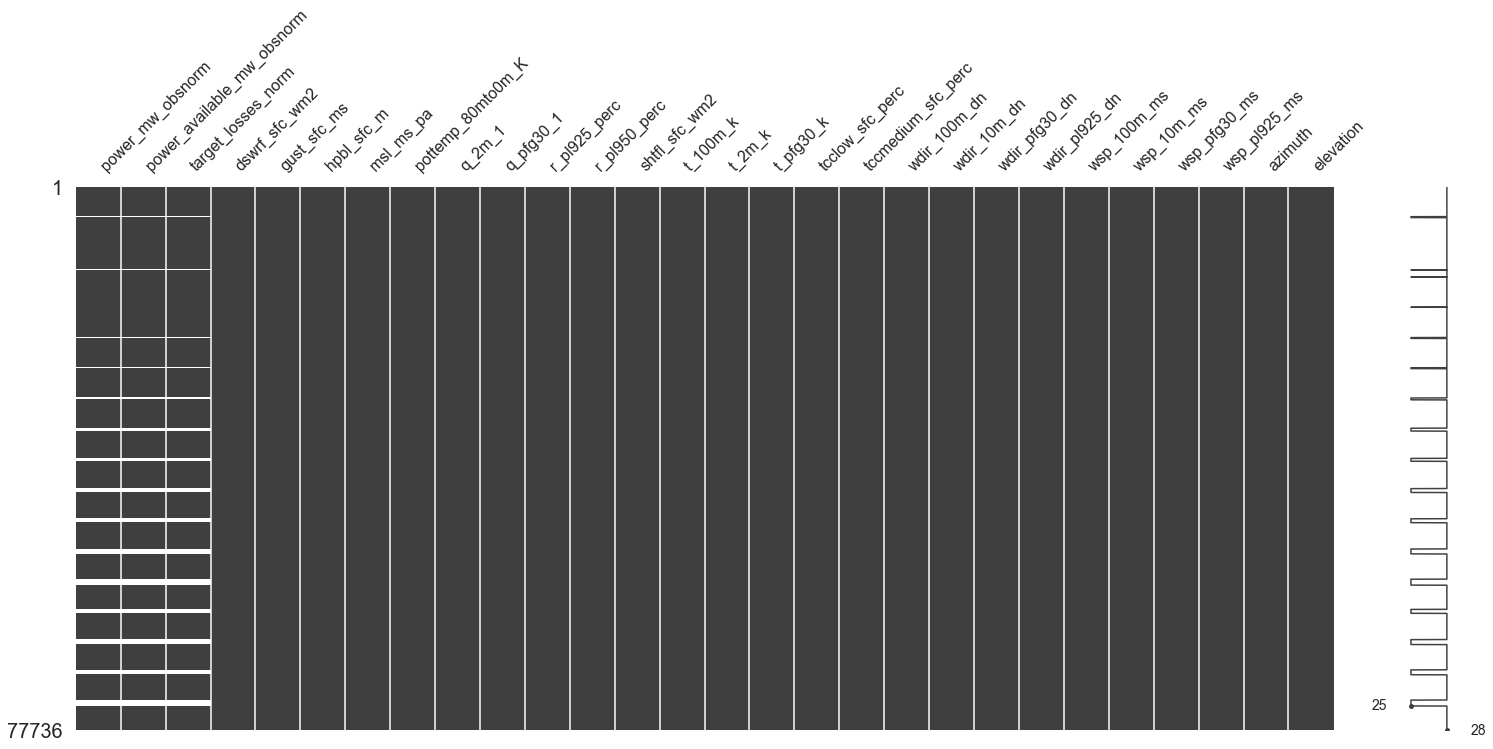

In [63]:
msno.matrix(df);

## Checking for duplicate timestamps

In [64]:
np.any(df.index.duplicated())

False

There are no duplicate timestamps in the dataframe.

## Uncontinuous target Data

**Problem:** As described above, while working on the dataset it got obvious that the target data (target_losses) are not contentious, e.g., certain timeframes where missing. 

**Solution:** as an interpolation strategy the *Standard Week* is computed, a representation of the average hour on every day of the week, e.g., a 'Standard Monday', a 'Standard Tuesday'. This Standard Week is then used to fill the data gap. This is done for all three target data features (e.g., power_mw_obsnorm, power_available_mw_obsnorm,  target_losses_norm). 

### Inspection of uncontinuous  target Data

At first glance, the data seems continuous: 

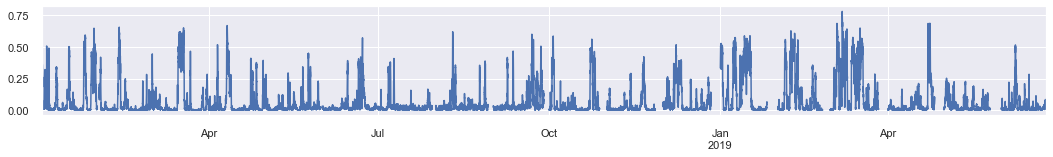

In [65]:
df.target_losses_norm.plot(figsize=(18, 2));

But inspecting very close, there are gabs within the target data:

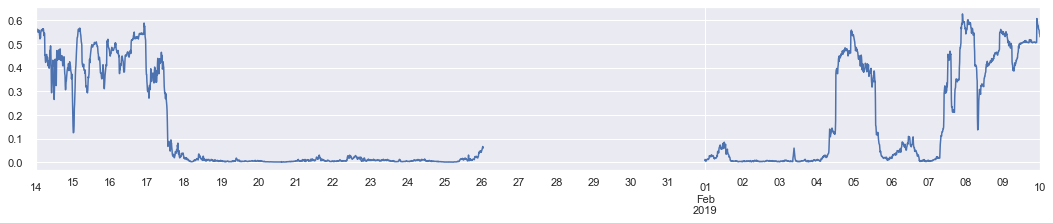

In [66]:
start_index = pd.to_datetime("2019-01-14 00:00:00")
end_index = pd.to_datetime("2019-02-10 00:00:00")
df.target_losses_norm[start_index:end_index].plot(figsize=(18, 3));

### Dealing with uncontentious target Data

In [67]:
df['index1'] = df.index
df['Date'] = pd.to_datetime(df.index1.dt.date)
df['year'] = df.index1.dt.year
df['month'] = df.index1.dt.month
df['day'] = df.index1.dt.day
df['hour'] = df.index1.dt.hour
df['minute'] = df.index1.dt.minute

weekdays = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3: 'Thursday', 4: 'Friday', 5:'Saturday', 6:'Sunday'}
df['weekday'] = df.index1.dt.weekday.map(weekdays)

df['day_hour_minute'] = df.index1.dt.weekday + df['hour']*1/24 + (df['minute']//10 * 1/144)


df.drop(columns = ["index1"], inplace = True)
df.head(2)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,day_hour_minute
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,0.250000
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,0.256944


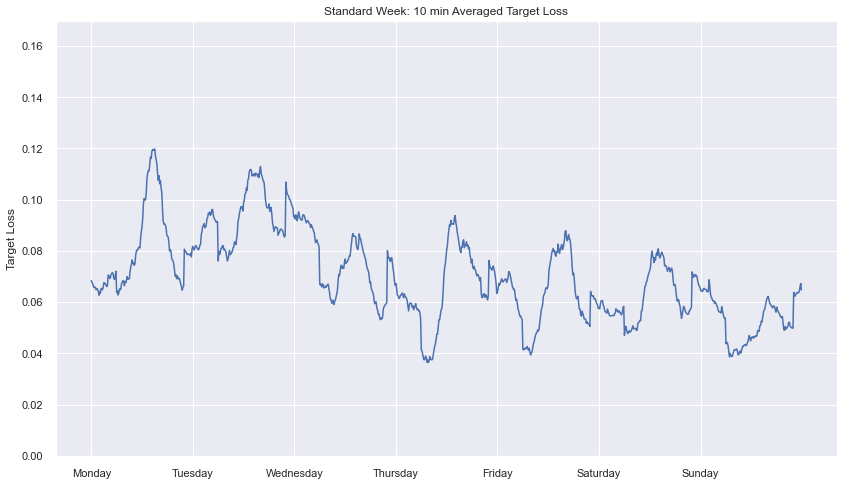

In [68]:
#Plotting average hourly load profile observed over the entire period 
df.groupby('day_hour_minute')['target_losses_norm'].mean().plot(figsize = (14,8))
_ = plt.ylabel('Target Loss')
_ = plt.xlabel('')
_ = plt.ylim([0, max(df.groupby('day_hour_minute')['target_losses_norm'].mean()) + 0.05])
#the xticks are values between 0 and 7 (e.g., just like day_hour_minute), hence the np.arange() command
_ = plt.xticks(np.arange(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
_ = plt.title('Standard Week: 10 min Averaged Target Loss')

In [69]:
# creating series objects with the different timestamps of a day and their corresponding mean values for target data
day_hour_minute_means_loss = df.groupby('day_hour_minute')['target_losses_norm'].mean().reset_index()
day_hour_minute_means_available = df.groupby('day_hour_minute')['power_available_mw_obsnorm'].mean().reset_index()
day_hour_minute_means_cons = df.groupby('day_hour_minute')['power_mw_obsnorm'].mean().reset_index()

# creating dictionaries to map the mean values to the according timestamps
day_hour_minute_means_loss_dict = dict(zip(day_hour_minute_means_loss.day_hour_minute, day_hour_minute_means_loss.target_losses_norm))
day_hour_minute_means_available_dict = dict(zip(day_hour_minute_means_available.day_hour_minute, day_hour_minute_means_available.power_available_mw_obsnorm))
day_hour_minute_means_cons_dict = dict(zip(day_hour_minute_means_cons.day_hour_minute, day_hour_minute_means_cons.power_mw_obsnorm))

# mapping the mean values to the according timestamps
df["mean_losses"] = df["day_hour_minute"].map(day_hour_minute_means_loss_dict)
df["mean_available"] = df["day_hour_minute"].map(day_hour_minute_means_available_dict)
df["mean_cons"] = df["day_hour_minute"].map(day_hour_minute_means_cons_dict)

# filling in the nan values in our target data with the mean value for the corresponding timestamp on the day
df["target_losses_norm"].fillna(df["mean_losses"], inplace=True)
df["power_available_mw_obsnorm"].fillna(df["mean_losses"], inplace=True)
df["power_mw_obsnorm"].fillna(df["mean_losses"], inplace=True)

# dropping the columns with the mean values again
df.drop(columns = ["mean_losses", "mean_available", "mean_cons", "day_hour_minute"], inplace = True)

df.head(2)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday


In [70]:
# Percentage and Number of NaN-Values
missing = pd.DataFrame(df.isnull().sum(),columns=['Number'])
missing['Percentage'] = round(missing.Number/df.shape[0]*100,1)
print()
print('MISSING VALUES (absolut and in percent)')
missing[missing.Number!=0].T


MISSING VALUES (absolut and in percent)


""
Number
Percentage


### Solution: continious target Data

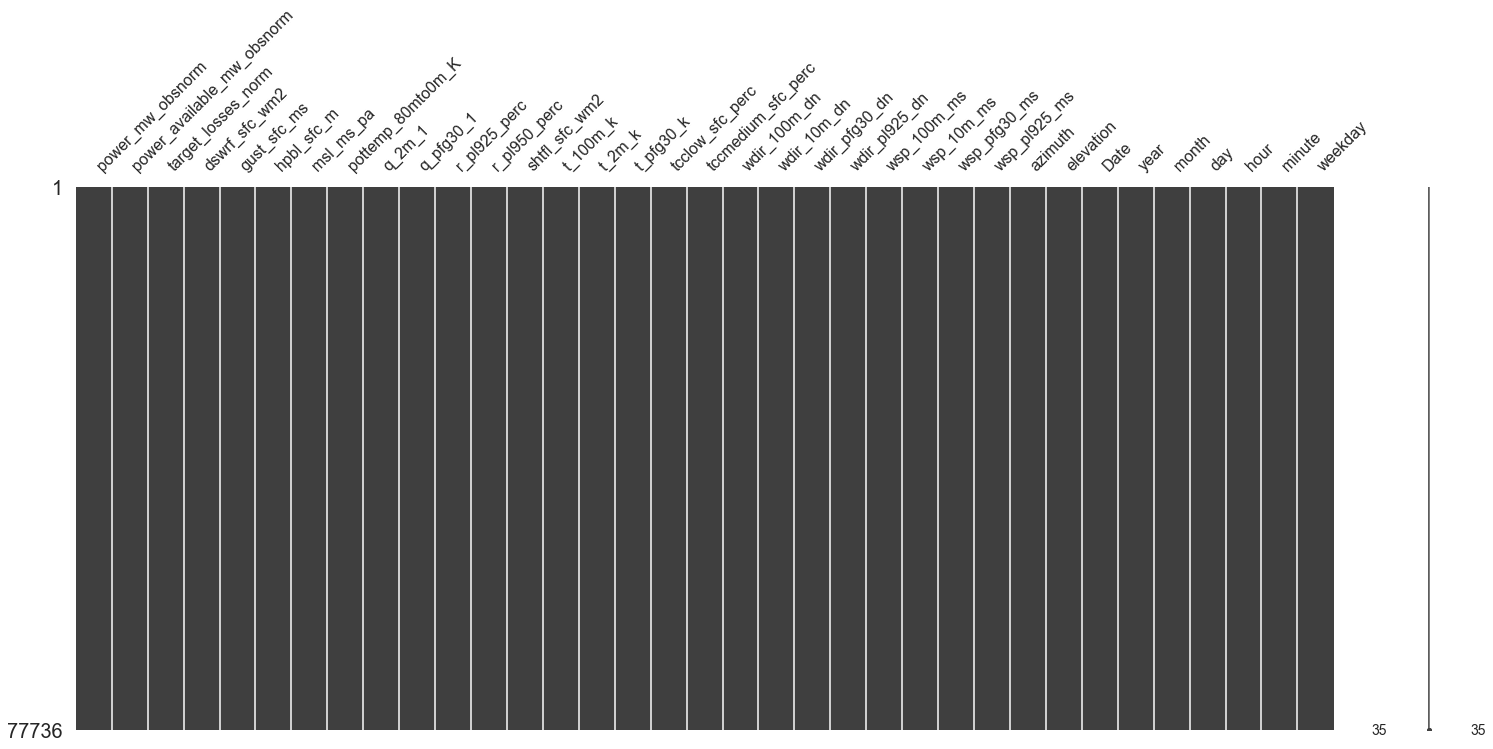

In [71]:
msno.matrix(df);

**Observation:** In the following graph, the data gap is filled. 

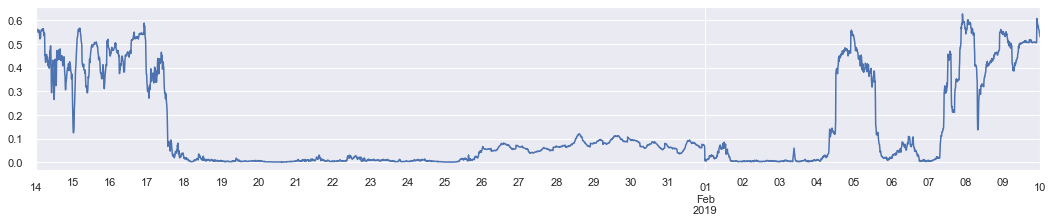

In [72]:
start_index = pd.to_datetime("2019-01-14 00:00:00")
end_index = pd.to_datetime("2019-02-10 00:00:00")
df.target_losses_norm[start_index:end_index].plot(figsize=(18, 3));

# Data Exploration

## Hourly Frequence Analysis

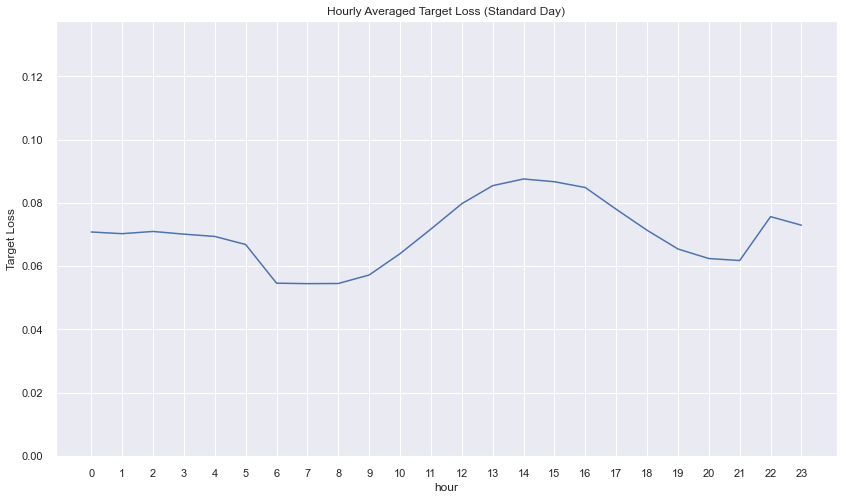

In [73]:
#Plotting average hourly load profile observed over the entire period 
df.groupby('hour')['target_losses_norm'].mean().plot(figsize = (14,8))
_ = plt.ylabel('Target Loss')
_ = plt.ylim([0, max(df.groupby('hour')['target_losses_norm'].mean()) + 0.05])
_ = plt.xticks(df['hour'].unique())
_ = plt.title('Hourly Averaged Target Loss (Standard Day)')

**Observations:**
- **Afternoon** energy loss through Feed-In Management Events. This is potentially explained by greater solar energy production in the afternoon. 
- **Evening** energy loss, potentially explained by the availability of wind energy in the evenings (sea breeze, as explained below). 


>  A sea breeze or onshore breeze is any wind that blows from a large body of water onto a landmass; it develops due to differences in air pressure created by the differing heat capacities of water and dry land. Because land absorbs solar radiation far more quickly than water, a sea breeze is a common occurrence along coasts **after sunrise**. As such, sea breezes are more localised than prevailing winds. **Wind farms are often situated near a coast to take advantage of the normal daily fluctuations of wind speed resulting from sea or land breezes**. [Wikipedia - Sea Breeze](https://en.wikipedia.org/wiki/Sea_breeze)

## Seasonality Analysis

In [74]:
#Using pivot table to create a dataframe having index as hours and columns as weekdays and each cell will contain the average
#energy consumption for that particular hour of the weekday

hour_weekday = df.pivot_table(values='target_losses_norm', index='hour', columns = 'weekday', aggfunc = 'mean')
columns = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
hour_weekday = hour_weekday[columns]

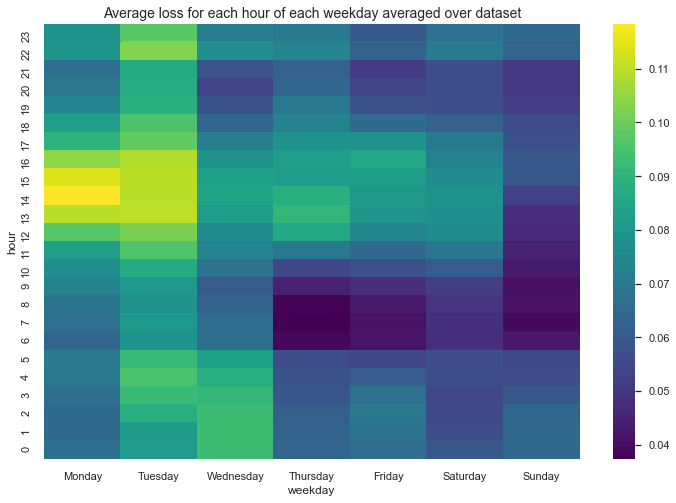

In [75]:
#plotting a heatmap with a colorbar; the colorbar shows the energy consumption in MWH
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday.sort_index(ascending = False), cmap='viridis')
#_ = plt.title('Average energy consumption in MWH for each hour of each weekday over the entire period')
_ = ax.set_title("Average loss for each hour of each weekday averaged over dataset", fontsize = 14)


In [76]:
#Using pivot table to create a dataframe having index as hours and columns as weekdays and each cell will contain the average
#energy consumption for that particular hour of the weekday

hour_weekday_consumed = df.pivot_table(values='power_mw_obsnorm', index='hour', columns = 'weekday', aggfunc = 'mean')
columns = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
hour_weekday_consumed = hour_weekday[columns]


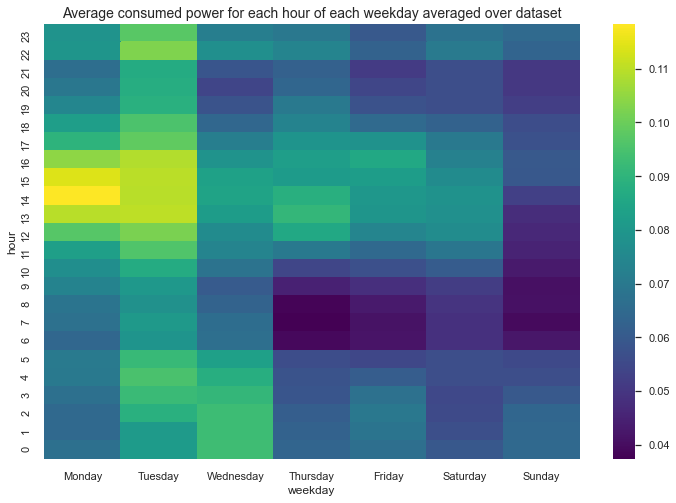

In [77]:
#plotting a heatmap with a colorbar; the colorbar shows the energy consumption in MWH
_ = plt.figure(figsize=(12, 8))
ax = sns.heatmap(hour_weekday_consumed.sort_index(ascending = False), cmap='viridis')
#_ = plt.title('Average energy consumption in MWH for each hour of each weekday over the entire period')
_ = ax.set_title("Average consumed power for each hour of each weekday averaged over dataset", fontsize = 14)


Observations: 
- consumed power is not representative for the overall power consumption of the local grid, but rather for the amount of wind power fed into the grid (normed on the maximum available power = installed power)

## Adding column working day

Since the energy consumption in the grid might be correlated to the day being a working or non working day, a feature called working day is implemented. All the weekend days and the national holidays for Germany will be categorized as non-working days.

In [78]:
#workalendar is a non-standard, single-use libary 
#workalendar is hence is loaded seperate
try:
    import workalendar
    print("module 'workalendar' is installed.")
except ModuleNotFoundError:
    print("module 'workalendar' will be installed and imported.")
    print()
    ! pip install workalendar
    import workalendar

module 'workalendar' is installed.


In [79]:
from workalendar.europe import Germany
cal = Germany()
df["working_day"] = df["Date"].apply(lambda x: cal.is_working_day(x))
df.head(2)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,working_day
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,False
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,False


## Adding column season

Since the location of our wind farm is in northern Germany we will apply a filter on our dataset that separates the dates into two basic seasons (summer and winter). As the summer in northern Germany tends to be shorter, only the months from May to August will be declared summer months.

In [80]:
def season_calc(month):
    if month in [5,6,7,8]:
        return 1 #"summer"
    else:
        return 0 #"winter"
    
df['summer'] = df.Date.dt.month.apply(season_calc)
df.head(2)

,power_mw_obsnorm,power_available_mw_obsnorm,target_losses_norm,dswrf_sfc_wm2,gust_sfc_ms,hpbl_sfc_m,msl_ms_pa,pottemp_80mto0m_K,q_2m_1,q_pfg30_1,r_pl925_perc,r_pl950_perc,shtfl_sfc_wm2,t_100m_k,t_2m_k,t_pfg30_k,tcclow_sfc_perc,tccmedium_sfc_perc,wdir_100m_dn,wdir_10m_dn,wdir_pfg30_dn,wdir_pl925_dn,wsp_100m_ms,wsp_10m_ms,wsp_pfg30_ms,wsp_pl925_ms,azimuth,elevation,Date,year,month,day,hour,minute,weekday,working_day,summer
2018-01-01 06:00:00,0.486251,0.911849,0.425598,0.0,16.777032,1349.927656,99212.062500,0.559356,0.005105,0.004852,89.975000,83.0750,-58.444885,280.079346,280.496348,279.811816,99.375000,49.500000,54.455224,51.936818,54.855777,58.963042,16.548291,9.772748,16.622077,21.963719,111.880959,-12.132894,2018-01-01,2018,1,1,6,0,Monday,False,0
2018-01-01 06:10:00,0.528225,0.932739,0.404513,0.0,16.748651,1350.376965,99220.020833,0.554256,0.005088,0.004833,89.854167,82.9375,-58.558706,280.057788,280.470277,279.787207,99.354167,54.458333,55.784078,53.253883,56.181451,60.237190,16.589409,9.804977,16.657162,21.955989,113.717751,-10.743970,2018-01-01,2018,1,1,6,10,Monday,False,0


## Graph: Power Available vs Power fed into the grid

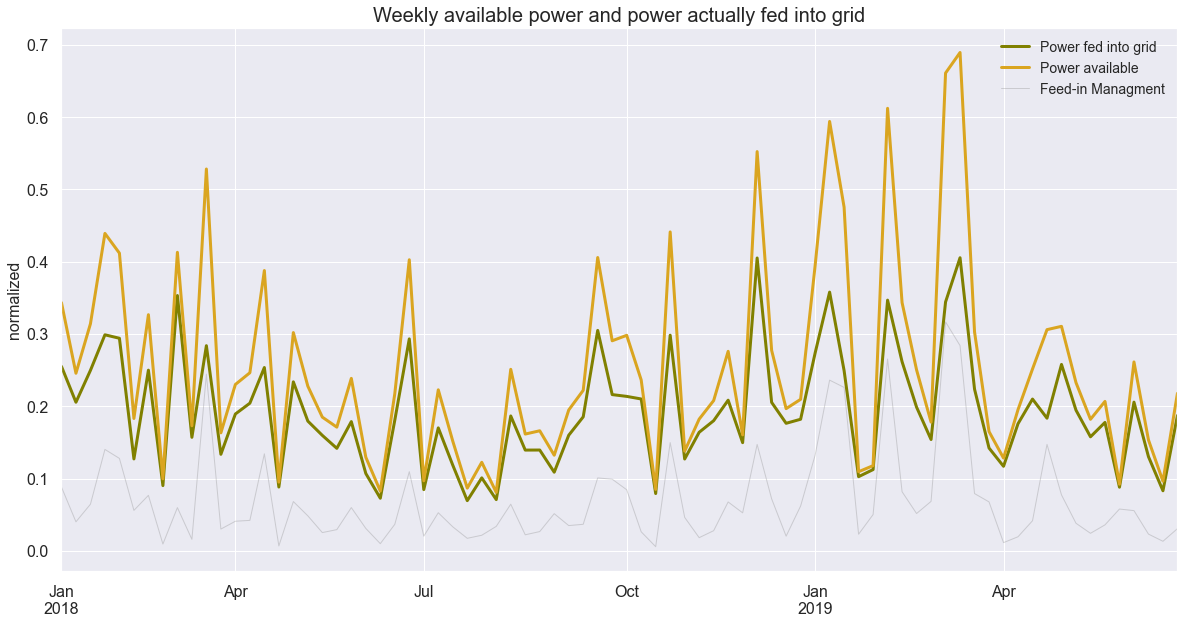

In [81]:
###### DATA SELECTION ###### 
weekly_feedin = df['power_mw_obsnorm'].resample('W').mean()
weekly_available = df['power_available_mw_obsnorm'].resample('W').mean()
weekly_loss = df['target_losses_norm'].resample('W').mean()
###### DATA PLOTTING ###### 
fig, ax = plt.subplots(figsize=(20,10))
weekly_feedin.plot(label='Power fed into grid',color='olive', lw=3)
weekly_available.plot(label='Power available',color='goldenrod', lw=3)
weekly_loss.plot(label='Feed-in Managment',color='grey', alpha=0.3,  lw=1)

### Moving Mean
#moving_mean = df['power_mw_obsnorm'].resample('W').mean().rolling(4).mean()
#moving_mean.plot(label='Power available',color='green')
######


###### PLOT SETTINGS #######
plt.ylabel('normalized', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('Weekly available power and power actually fed into grid', fontsize=20)
plt.legend(loc='upper right', fontsize=14)

### CLEANING WORKSPACE ###
del weekly_feedin, weekly_available, weekly_loss


###### OUTPUT #######
plt.savefig('figures/available_fedin.png', bbox_inches='tight', transparent=True)
plt.show;

**Observation:** At any given week, the available power is greater than the power fed into the grid (used power). Hence, at any given week curtailment of power fed into the system is observable (feed-in managment / EinsMan Events). In an ideal week, the power available nearly equals the power used/fed into the grid - a balanced energy grid with very little energy being lost (read: not created, e.g., due to pitching of wind turbine blades). 

## Graph: Influence of Wind on the Feed-In Management [weekly]

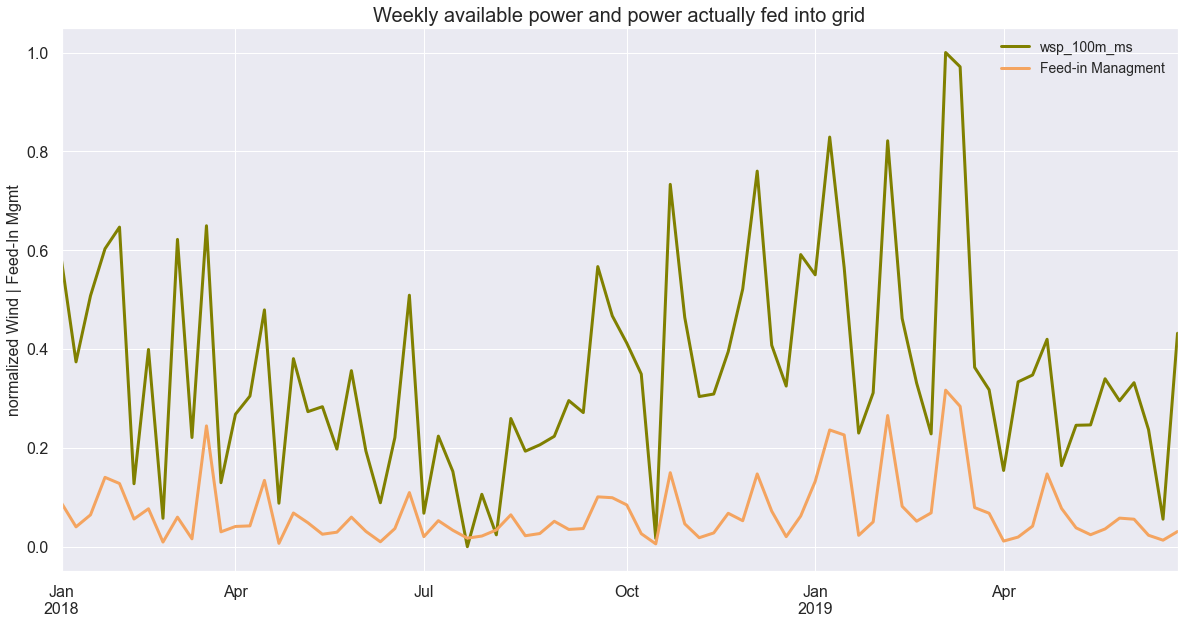

In [82]:
###### DATA SELECTION ###### 
weekly_wsp = df['wsp_100m_ms'].resample('W').mean()
weekly_wsp = (weekly_wsp-weekly_wsp.min())/(weekly_wsp.max()-weekly_wsp.min())
weekly_loss = df['target_losses_norm'].resample('W').mean()
###### DATA PLOTTING ###### 
fig, ax = plt.subplots(figsize=(20,10))
weekly_wsp.plot(label='wsp_100m_ms',color='olive', lw=3)
weekly_loss.plot(label='Feed-in Managment',color='sandybrown',  lw=3)


###### PLOT SETTINGS #######
plt.ylabel('normalized Wind | Feed-In Mgmt', fontsize=16)
plt.tick_params(labelsize=16)
plt.title('Weekly available power and power actually fed into grid', fontsize=20)
plt.legend(loc='upper right', fontsize=14)

### CLEANING WORKSPACE ###
del weekly_wsp, weekly_loss


###### OUTPUT #######
plt.savefig('figures/wind_FeedIn.png', bbox_inches='tight', transparent=True)
plt.show;

**Observation:** On a weekly bases, only little correlation between high windspeeds and Feed-In Managment can be observered. `-->` Looking at a smaller timespan at higher resultion in the next step. 

## Graph: Influence of Wind on the Feed-In Management [daily]

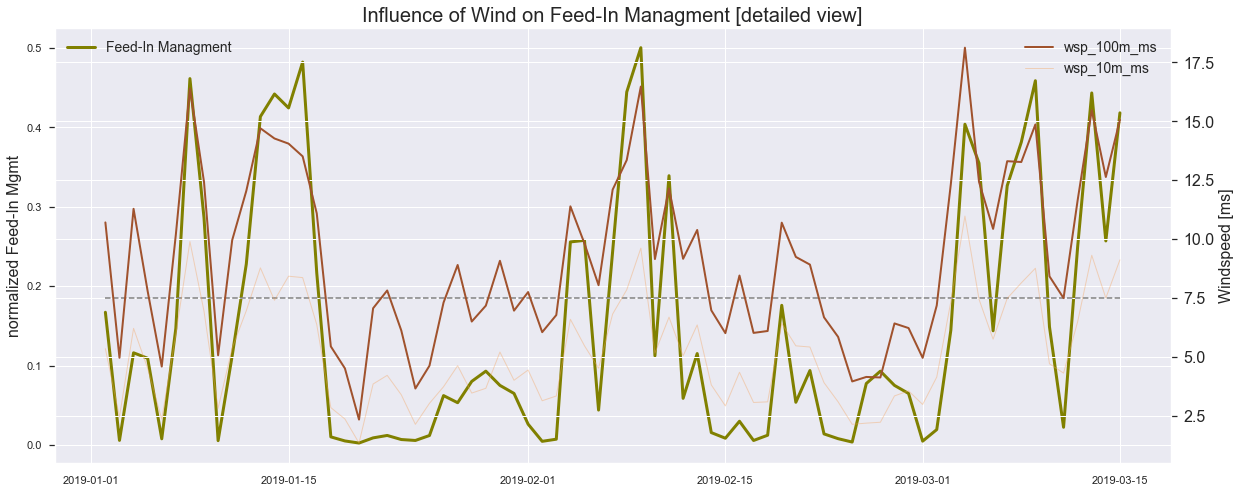

In [83]:
###### DATA SELECTION ###### 
start_index = pd.to_datetime("2019-01-02 00:00:00")
end_index = pd.to_datetime("2019-03-15 00:00:00")
#reduced timeframe
df_reduced = df[(df.index <= end_index) & (df.index >= start_index)]
#resampling
weekly_wsp_100 = df_reduced['wsp_100m_ms'].resample('D').mean()
weekly_wsp_10 = df_reduced['wsp_10m_ms'].resample('D').mean()
weekly_loss = df_reduced['target_losses_norm'].resample('D').mean()

###### DATA PLOTTING ###### 
fig, ax1 = plt.subplots(figsize=(20,8))
#left axis
ax1.set_ylabel('normalized Feed-In Mgmt', fontsize=16)
ax1.plot(weekly_loss, label='Feed-In Managment',color='olive',  lw=3)
ax1.legend(loc='upper left', fontsize=14)
#right axis
ax2 = ax1.twinx()
ax2.plot(weekly_wsp_100, label='wsp_100m_ms',color='sienna', lw=2)
ax2.plot(weekly_wsp_10, label='wsp_10m_ms',color='sandybrown', lw=1, alpha=0.4)
ax2.legend(loc='upper right', fontsize=14)
ax2.set_ylabel('Windspeed [ms]', fontsize=16)
ax2.legend(loc='upper right', fontsize=14)
#general settings
plt.tick_params(labelsize=16)
plt.title('Influence of Wind on Feed-In Managment [detailed view]', fontsize=20)
plt.hlines(7.5, start_index, end_index, linestyles='dashed', colors = 'grey')

### CLEANING WORKSPACE ###
del weekly_wsp_100, weekly_wsp_10, weekly_loss

###### OUTPUT #######
plt.savefig('figures/wind_FeedIn_detail.png', bbox_inches='tight', transparent=True)
plt.show;

**Observations:** 
- As a rule-of-thumb, for `wsp_10m_m`, windspeeds above a certain value (e.g., 7.5 ms) stimulate the Feed-In Management exponential
- windspeed at 100m above ground is highly corrolated to windspeed at 10m above ground. `wsp_10m_ms` is the windspeed at turbine height, hence `wsp_10m_m` will be dropped

## Correlation of features with target_losses_norm

To get a feel for the importance of different features the features with the largest absolute correlation coefficients and the correlations inbetween them will be examined with a heatmap.

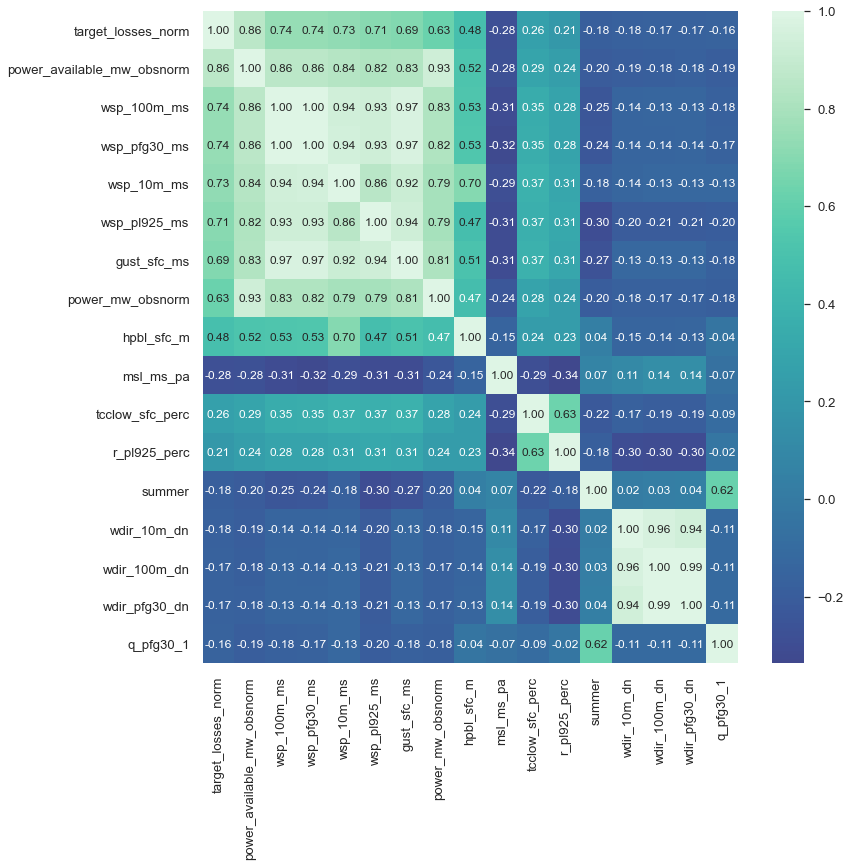

In [84]:
k = 17 #number of variables for heatmap
cols_corr_mat = np.abs(df.corr()).nlargest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(df[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.2f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

In order to check the correlation of our target variable with past observations of available and consumed power a dataframe with the lagged values is created and the correlation checked in a heatmap.

In [85]:
heatmap = df[["target_losses_norm","power_mw_obsnorm", "power_available_mw_obsnorm"]].copy(deep= True)
heatmap.head()

,target_losses_norm,power_mw_obsnorm,power_available_mw_obsnorm
2018-01-01 06:00:00,0.425598,0.486251,0.911849
2018-01-01 06:10:00,0.404513,0.528225,0.932739
2018-01-01 06:20:00,0.405137,0.500030,0.905168
2018-01-01 06:30:00,0.481961,0.436176,0.918136
2018-01-01 06:40:00,0.497063,0.423738,0.920801


In [86]:
for i in range(1,6):
    heatmap[f"power_mw_obsnorm_{i*10}"] = heatmap["power_mw_obsnorm"].shift(i)
    heatmap[f"power_available_mw_obsnorm_{i*10}"] = heatmap["power_available_mw_obsnorm"].shift(i)

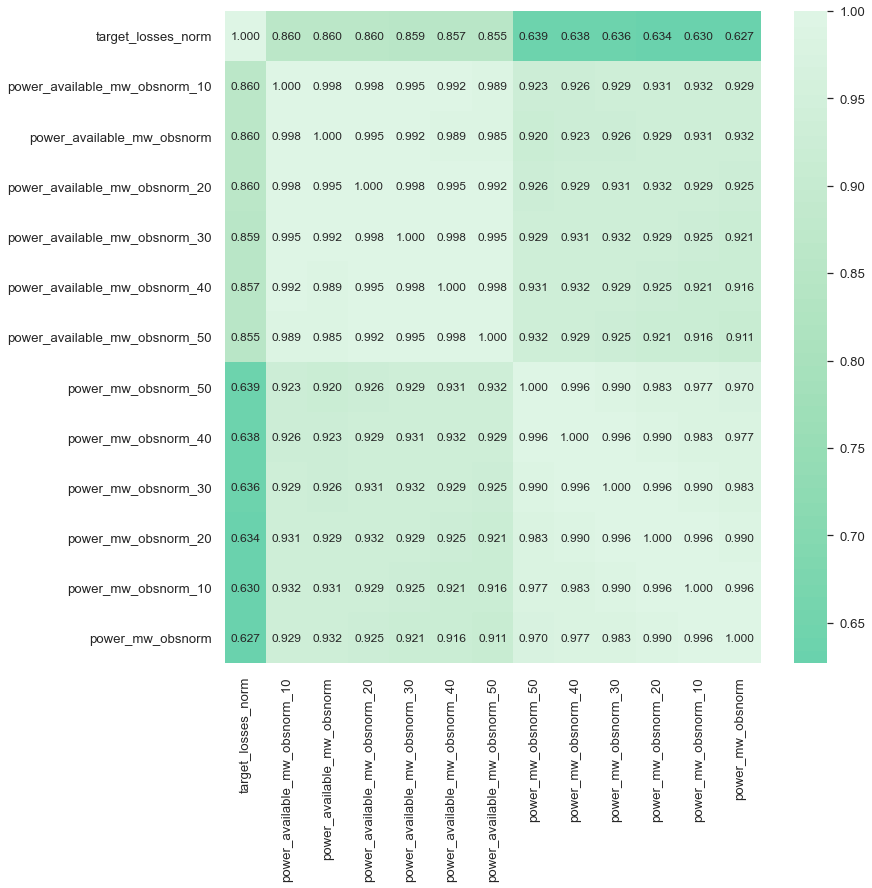

In [87]:
k = 15 #number of variables for heatmap
cols_corr_mat = np.abs(heatmap.corr()).nlargest(k, 'target_losses_norm')['target_losses_norm'].index
cm = np.corrcoef(heatmap[cols_corr_mat].dropna().values.T)
sns.set(font_scale=1.2)
plt.subplots(figsize=(12,12))
hm = sns.heatmap(cm, annot=True, fmt='.3f', annot_kws={'size': 12},
                 yticklabels=cols_corr_mat.values, xticklabels=cols_corr_mat.values, cmap='mako', center=0.0)
plt.show()

**Observations:**  

- the difference in correlation for the last observed values and the 6 lagged value is insignificant
- the columns power_mw_obsnorm and power_available_mw_obsnorm do not carry additional information, since the difference between them creates our target value